## Construção do modelo de clustering:
Implementar um modelo de clustering usando o algoritmo K-Means para segmentar os clientes em grupos homogêneos baseados em suas características demográficas e comportamentais.

In [1]:
import os


os.environ["OMP_NUM_THREADS"] = "1" #evitar o warning do kmeans
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    OneHotEncoder, 
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

from src.config import DADOS_LIMPOS, MODELO, DADOS_CLUSTERED
from src.graficos import graficos_elbow_silhouette
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette='tab10')


In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [4]:
# Agrupamento das colunas de acordo com o pré-processamebto necessário
colunas_numericas = list(df.select_dtypes("number").columns)
coluna_categorica = ["Gender"]
colunas_numericas

['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Fluxo da Análise:
1. Pré-processamento dos Dados:
Transformação de Variáveis:

Variáveis categóricas (Gender) são codificadas via OneHotEncoder

Variáveis numéricas são transformadas usando PowerTransformer para normalizar distribuições

Normalização: Essencial para algoritmos baseados em distâncias como K-Means

In [5]:
# Preprocessamento
preprocessamento = ColumnTransformer(
    [
        ("one_hot", OneHotEncoder(drop='first'), coluna_categorica),  #"first"
        ("PowerTransformer",PowerTransformer(), colunas_numericas),     
    ]
)



In [6]:
# criar dataframe com os dados preprocessados
df_scaled = pd.DataFrame(
    preprocessamento.fit_transform(df),
    columns= preprocessamento.get_feature_names_out(),
)


2. Determinação do Número Ótimo de Clusters:
 
Método Elbow e Silhouette Score e análise dos dados através da análise exploratória

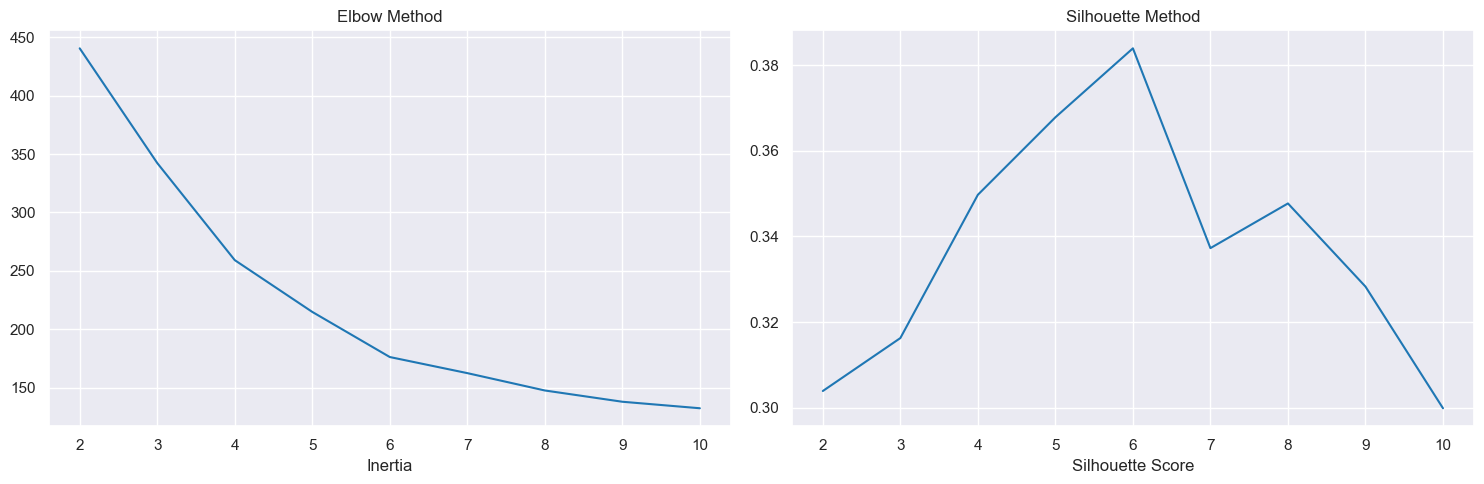

In [7]:
#função que cria gr
graficos_elbow_silhouette(df_scaled)            

O método elbow indica entre 4 e 6  clusters, já o silhouete indica 6.
Considerando essas informações junto com as observações feitas na análise exploratória, vou optar por 5 clusters.

3. Aplicação do K-Means:
   
Modelo treinado com n_clusters=5 e random_state=42 para reprodutibilidade

Pipeline integrando pré-processamento e modelagem

In [8]:
# Pipeline
pipeline = Pipeline([
    ('preprocessamento', preprocessamento),
    ('kmeans', KMeans(n_clusters=4, random_state=42, n_init=10))  
])

In [9]:
pipeline.fit(df)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender']),
                                                 ('PowerTransformer',
                                                  PowerTransformer(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score '
                                                   '(1-100)'])])),
                ('kmeans', KMeans(n_clusters=4, n_init=10, random_state=42))])

In [20]:
#para visualizar os dados originais clusterizados
df_clustered = df.copy()
df_clustered['Cluster']=  pipeline.named_steps['kmeans'].labels_
df_clustered.to_parquet(DADOS_CLUSTERED, index=False)
df_clustered.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,2
1,Male,21,15,81,2
2,Female,20,16,6,2
3,Female,23,16,77,2
4,Female,31,17,40,2


In [11]:
colunas_plot =colunas_numericas + ['Cluster']
colunas_plot

['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']

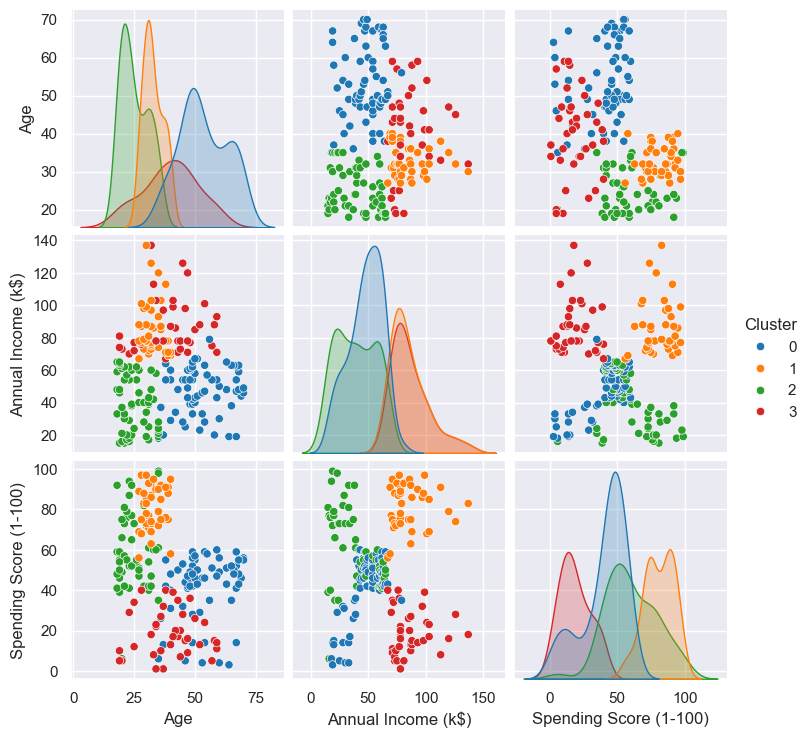

In [12]:
# Criar o pairplot visualizando a distribuição dos clusters. 

sns.pairplot(df_clustered[colunas_plot], diag_kind='kde', hue='Cluster', palette='tab10')
plt.show()

In [13]:
#O gráfico acima ajuda a entender a distribuição dos clusters, mas como o gráfico 2d, os clusters podem parecer coincidentes, mesmo não sendo.

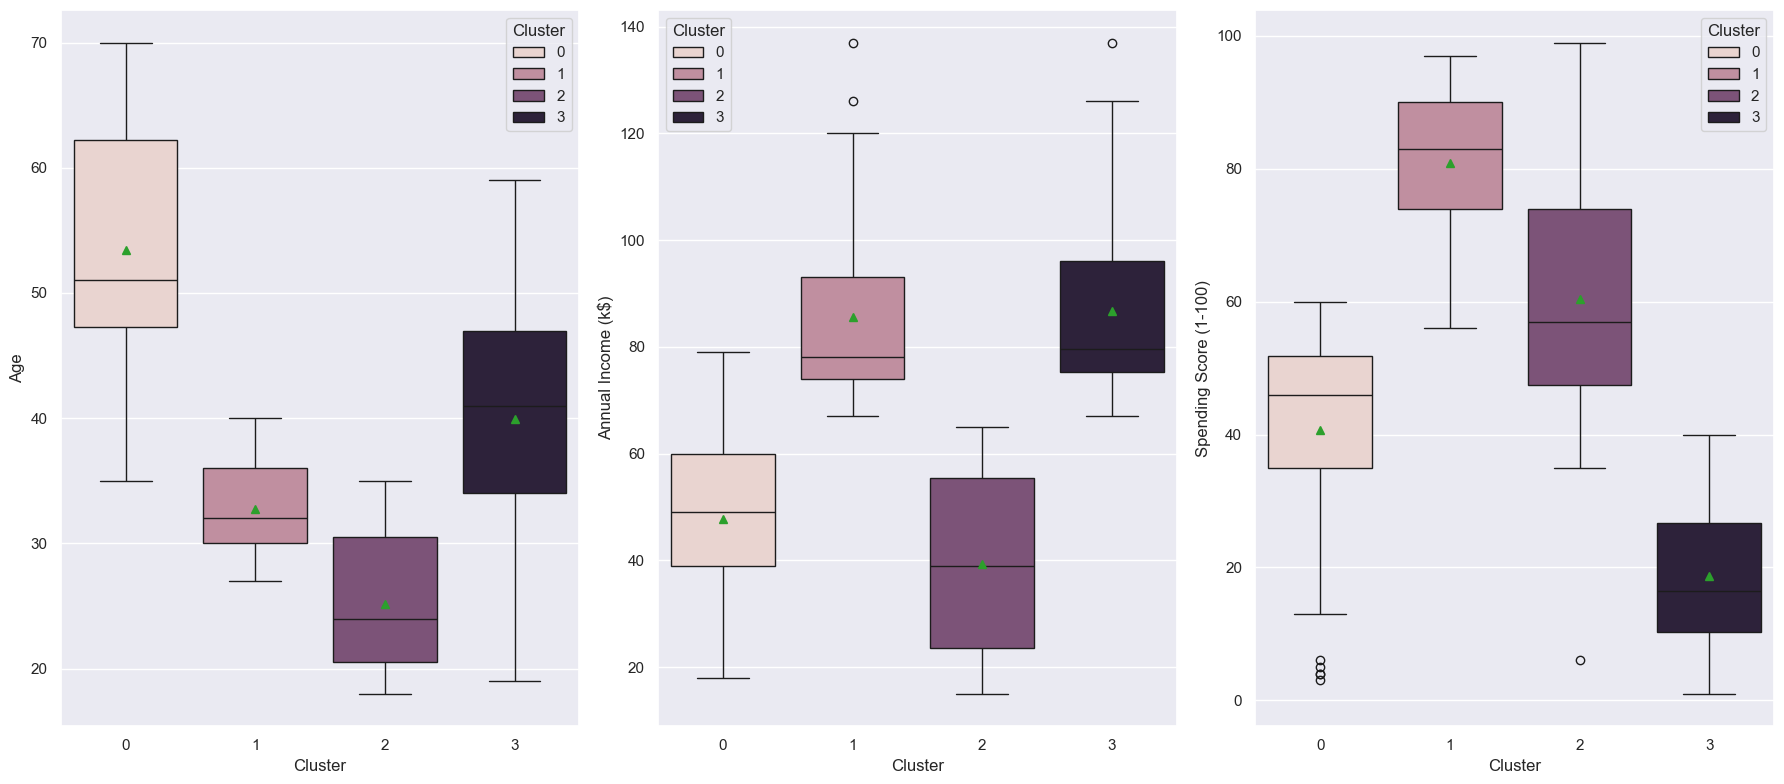

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
for ax, coluna in zip(axs.flatten(), df_clustered[colunas_plot]):
    sns.boxplot(y=coluna, ax=ax, data=df_clustered[colunas_plot], showmeans=True, x="Cluster", hue="Cluster")

plt.tight_layout()
plt.show()

- Cluster 0 - Pontuação de gastos altos, renda baixa, jovens 
- Cluster 1 - Pontuação de gastos baixos, renda baixa, idade moderada
- Cluster 2 - Pontuação de gastos altos, renda alta, jovens adultos
- Cluster 3 - Pontuação de gastos baixo, renda alta, moderada
- Cluster 4 - Pontuação de gastos moderados, renda moderada, idade alta 

transformando os pontos acima em uma tabela:

Pontuação de gastos | Renda | Idade | Número Cluster
--- | --- | --- | ---
Altos | Moderada | Jovens | 0
Baixos | Baixo | Moderada | 1
Altos | Alta | Jovens Adultos | 2
Baixos | Alta | Moderada | 3
Moderados | Moderado | Alta | 4


In [15]:
#tamanho de cada cluster
df_clustered["Cluster"].value_counts(normalize=True).mul(100).sort_index()


Cluster
0    33.0
1    20.5
2    27.5
3    19.0
Name: proportion, dtype: float64

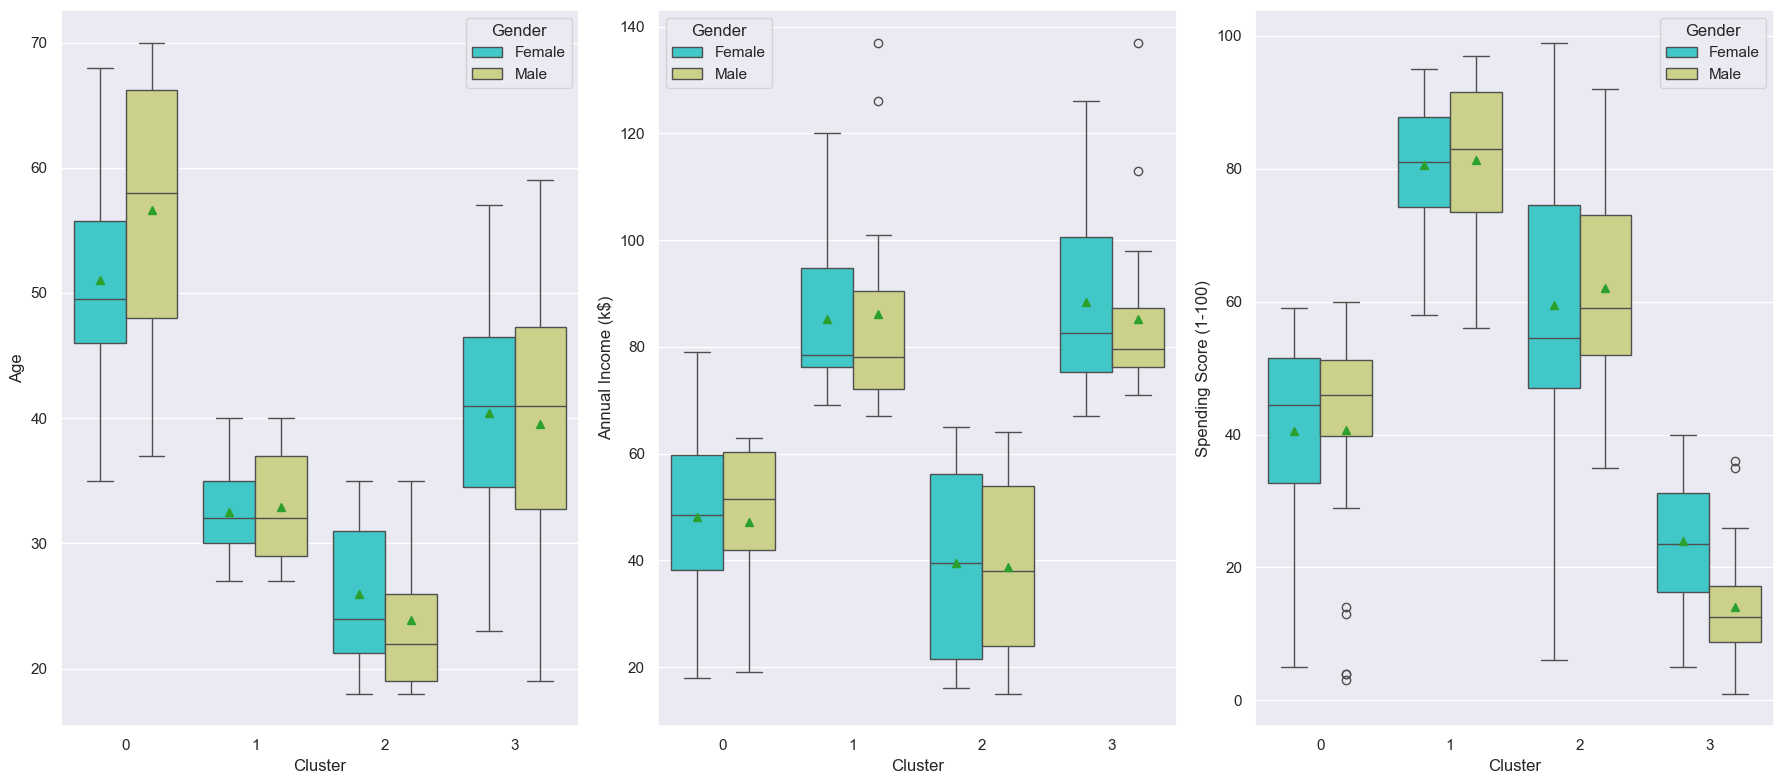

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes("number").columns):
    sns.boxplot(y=coluna, ax=ax, data=df_clustered, showmeans=True, x="Cluster", hue="Gender", palette='rainbow')

plt.tight_layout()
plt.show()


In [17]:
#composição de cada cluster considerando a composição por gênero
df_clustered.groupby(by=["Cluster", "Gender"]).size()


Cluster  Gender
0        Female    38
         Male      28
1        Female    22
         Male      19
2        Female    34
         Male      21
3        Female    18
         Male      20
dtype: int64

In [18]:
joblib.dump(pipeline, MODELO)


['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\projeto_clustering_clientes_supermercado\\modelos\\modelo_clustering.pkl']

## Conclusão

O modelo identificou 5 clusters com perfis distintos:

Cluster 2 (19.5%): Alto potencial (alta renda + alto gasto) → Priorizar campanhas premium.

Cluster 4 (26.5%): Renda e gastos moderados + idade alta → Oferecer produtos de valor intermediário.

Cluster 1 (10%): Baixa renda e gastos → Evitar investimentos pesados.

Validação:

Diferenças por gênero foram observadas (ex.: Cluster 0 com 60% mulheres).

Aplicação:

Essa segmentação permite personalizar estratégias de marketing e otimizar alocação de recursos.